# 量子ダイナミクスシミュレーション

第二回の後半は、量子コンピュータの並列性を利用した計算の代表例として、量子系のダイナミクスシミュレーションについて学びます。

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$

## 量子系のダイナミクスとは

量子力学について少しでも聞いたことのある方は、量子力学の根幹にシュレーディンガー方程式というものが存在することを知っているかと思います。この方程式は

$$
i \hbar \frac{\partial}{\partial t} \ket{\psi (t)} = H \ket{\psi (t)}
$$

などと表現され、時刻$t$のある系の状態$\ket{\psi (t)}$の時間微分（左辺）が$\ket{\psi (t)}$へのハミルトニアンという演算子の作用で定まる（右辺）ということを表しています。ただしこの「微分形」の方程式は我々の目的には少し使いづらいので、ここでは等価な「積分形」にして

$$
\ket{\psi (t_1)} = \exp \left( -\frac{i}{\hbar} \int_{t_0}^{t_1} H dt \right) \ket{\psi (t_0)}
$$

と書いておきます。特に、ハミルトニアン$H$が直接時間に依存しない場合は

$$
\ket{\psi (t_1)} = \exp \left( -\frac{i}{\hbar} (t_1 - t_0) H \right) \ket{\psi (t_0)}
$$

です。以下このケースのみを考えます。量子状態に対する演算子（線形演算子）の指数関数もまた演算子なので、積分形のシュレーディンガー方程式は「$e^{-i/\hbar (t_1-t_0) H}$という演算子が系を時刻$t_0$の初期状態$\ket{\psi(t_0)}$から時刻$t_1$の状態$\ket{\psi(t_1)}$に発展させる」と読めます。さらに、定義上ハミルトニアンは「エルミート演算子」であり、それに虚数単位をかけて指数の冪にした$e^{-i/\hbar t H}$（以下これを時間発展演算子$U(t)$と呼びます）は「ユニタリ演算子」です（このあたりの線形代数の用語にあまり馴染みがなくても、そういうものかと思ってもらえれば結構です）。

ユニタリ演算子は量子計算の言葉で言えばゲートにあたります。したがって、ある量子系に関して、その初期状態を量子レジスタで表現でき、時間発展演算子を量子コンピュータの基本ゲートの組み合わせで実装できれば、その系のダイナミクス（＝時間発展）シミュレーションを量子コンピュータで行うことができます。

### 例：核磁気の歳差運動

$\newcommand{\upket}{\ket{\!\uparrow}}$
$\newcommand{\downket}{\ket{\!\downarrow}}$
$\newcommand{\rightket}{\ket{\!\rightarrow}}$
$\newcommand{\leftket}{\ket{\!\leftarrow}}$

シミュレーションの詳しい話をする前に、これまで量子力学と疎遠だった方のために、ハミルトニアンや時間発展とは具体的にどういうことか、簡単な例を使って説明します。

空間中に固定されたスピン$\frac{1}{2}$原子核一つを考えます。ある方向（Z方向とします）のスピン$\pm \frac{1}{2}$の状態をそれぞれ$\upket, \downket$で表します。量子力学に馴染みのない方のための説明例で大いに量子力学的な概念を使っていますが、何の話かわからなければ「2つの基底ケットで表現される、量子ビットのような物理系がある」と考えてください。量子ビットのような物理系なので、系の状態は一般に$\upket$と$\downket$の重ね合わせになります。

時刻$t_0$で系が$\ket{\psi(t_0)} = \upket$にあるとします。時刻$t_1$での系の状態を求めることは

$$
\ket{\psi (t_1)} = \alpha (t_1) \upket + \beta (t_1) \downket
$$

の$\alpha (t_1)$と$\beta (t_1)$を求めることに相当します。ここで$\alpha (t_0) = 1, \beta (t_0) = 0$です。

この原子核に$X$方向の一定磁場をかけます。非ゼロのスピンを持つ粒子はスピンベクトル$\vec{\sigma}$と平行な磁気モーメント$\vec{\mu}$を持ち、磁場$\vec{B}$のもとでエネルギー$-\vec{B}\cdot\vec{\mu}$を得ます。ハミルトニアンとは実は系のエネルギーを表す演算子なので、この一定磁場だけに注目した場合の系のハミルトニアンは、何かしらの定数$\omega$とスピンベクトルの$X$成分$\sigma_X$を用いて$H = \hbar \omega \sigma_X$と書けます。

量子力学では$\sigma_X$は演算子であり、$\upket$と$\downket$に対して

$$
\sigma_X \upket = \downket \\
\sigma_X \downket = \upket
$$

と作用します。時間発展演算子$U(t)$は

$$
U(t) = \exp (-i \omega t \sigma_X) = \sum_{n=0}^{\infty} \frac{1}{n!} (-i \omega t)^n \sigma_X^n = I + (-i \omega t) \sigma_X + \frac{1}{2} (-i \omega t)^2 \sigma_X^2 + \frac{1}{6} (-i \omega t)^3 \sigma_X^3 \cdots
$$

ですが（$I$は恒等演算子）、上の$\sigma_X$の定義からわかるように$\sigma_X^2 = I$なので

```{math}
:label: exp_sigmax
\begin{align}
\exp (-i \omega t \sigma_X) & = \left[ 1 + \frac{1}{2} (-i \omega t)^2 + \cdots \right] I + \left[(-i \omega t) + \frac{1}{6} (-i \omega t)^3 + \cdots \right] \sigma_X \\
& = \cos(\omega t) I - i \sin(\omega t) \sigma_X
\end{align}
```

と書けます。したがって、

```{math}
:label: spin_exact
\ket{\psi (t_1)} = U(t_1 - t_0) \ket{\psi (t_0)} = \exp [-i \omega (t_1 - t_0) \sigma_X] \upket = \cos[\omega (t_1 - t_0)] \upket - i \sin[\omega (t_1 - t_0)] \downket
```

です。任意の時刻$t_1$のスピンの状態が基底$\upket$と$\downket$の重ね合わせとして表現されました。

このように、系のエネルギーの表式からハミルトニアンが決まり、その指数関数を初期状態に作用させることで時間発展後の系の状態が求まります。

ちなみに、$\ket{\psi (t_1)}$は$t_1 = t_0$で$\upket$、$t_1 = t_0 + \pi / (2 \omega)$で$(-i)\downket$となり、以降$\upket$と$\downket$を周期的に繰り返します。実は、その間の状態はスピンが$Y$-$Z$平面内を向いている状態に相当します。スピンが0でない原子核に磁場をかけると、スピンと磁場の方向が揃っていなければ磁場の方向を軸にスピンが歳差運動（すりこぎ運動）をします。これはコマが重力中で起こす運動と同じで、核磁気共鳴（NMR、さらに医学応用のMRI）の原理に深く関わります。

### 量子コンピュータ上での表現

すでに触れましたが、上の例で核のスピンは量子ビットのように2つの基底ケットを持ちます（2次元量子系です）。さらに、お気づきの方も多いと思いますが、$\sigma_X$の$\upket$と$\downket$への作用は$X$ゲートの$\ket{0}$と$\ket{1}$への作用そのものです。このことから、核磁気の歳差運動が極めて自然に量子コンピュータでシミュレートできることがわかるかと思います。

実際には、時間発展演算子は$\sigma_X$そのものではなくその指数関数なので、量子コンピュータでも$\exp (-i \theta/2 X)$に対応する$R_{x} (\theta)$ゲートを利用します。これまで紹介されませんでしたが、$R_{x}$ゲートはパラメータ$\theta$をとり、

$$
R_{x}(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} - i\sin\frac{\theta}{2}\ket{1} \\
R_{x}(\theta)\ket{1} = -i\sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
$$

という変換を行います。上の核スピン系を量子コンピュータでシミュレートするには、1量子ビットで$R_{x} (2 \omega (t_1 - t_0)) \ket{0}$を計算する以下の回路を書けばいいだけです。

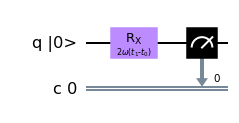

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

circuit = QuantumCircuit(QuantumRegister(1, 'q'), ClassicalRegister(1, 'c'))
circuit.rx(Parameter('$2 \omega (t_1 - t_0)$'), 0)
circuit.measure(0, 0)
circuit.draw('mpl', initial_state=True)

### ハミルトニアンの対角化

再び量子コンピュータを離れて、量子・古典に関わらずデジタル計算機で量子ダイナミクスのシミュレーションをする際の一般論をします。

上の核スピンの例ではハミルトニアンが単純だったので、式{eq}`spin_exact`のように厳密解が求まりました。特に、導出において$\sigma_X^2 = I$という恒等式が非常に重要でした。しかし、一般のハミルトニアンでは、何乗しても恒等演算子の定数倍にたどり着く保証がありません。

累乗して恒等演算子にならないようなハミルトニアンであっても、系の次元が小さい場合は「対角化」という作業で厳密解を得られます。ハミルトニアンの対角化とは、ハミルトニアンの作用が実数をかけることと等しくなるようなケットを探してくること、つまり

$$
H\ket{\phi_j} = \hbar \omega_j \ket{\phi_j}, \quad \omega_j \in \mathbb{R}
$$

が成り立つような$\ket{\phi_j}$を見つけることを指します。このような$\ket{\phi_j}$を「固有値$\hbar \omega_j$を持つ$H$の固有ベクトル」と呼びます。系の次元が$N$であれば、独立な固有ベクトルが$N$個存在します。

例えば上の例では$H = \hbar \omega \sigma_X$ですが、

$$
\rightket := \frac{1}{\sqrt{2}}(\upket + \downket) \\
\leftket := \frac{1}{\sqrt{2}}(\upket - \downket)
$$

という2つの状態を考えると

$$
\sigma_X \rightket = \rightket \\
\sigma_X \leftket = -\leftket
$$

なので、これらが固有値$\pm \hbar \omega$の$H$の固有ベクトルとなっていることがわかります。

ハミルトニアンの固有値$\hbar \omega_j$の固有ベクトル$\ket{\phi_j}$に対して、時間発展演算子は

$$
U(t) \ket{\phi_j} = \exp \left( -\frac{i}{\hbar} t H \right) \ket{\phi_j} = \exp (-i \omega_j t) \ket{\phi_j}
$$

のように作用するので、系の初期状態$\ket{\psi (t_0)}$が

$$
\ket{\psi (t_0)} = \sum_{j=0}^{N} c_j \ket{\phi_j}
$$

であれば、時刻$t_1$での状態は

$$
\ket{\psi (t_1)} = \sum_{j=0}^{N} c_j U(t_1 - t_0) \ket{\phi_j} = \sum_{j=0}^{N} e^{-i \omega_j (t_1 - t_0)} c_j \ket{\phi_j},
$$

つまり、各固有ベクトルの振幅に、対応する位相因子をかけるだけで求まります。

再び核スピンの例を見ると、初期状態$\ket{\psi(t_0)} = \upket = 1/\sqrt{2} (\rightket + \leftket)$なので、

$$
\begin{align}
\ket{\psi(t_1)} & = \frac{1}{\sqrt{2}} \left( e^{-i\omega (t_1 - t_0)} \rightket + e^{i\omega (t_1 - t_0)} \leftket \right) \\
& = \frac{1}{2} \left[ \left( e^{-i\omega (t_1 - t_0)} + e^{i\omega (t_1 - t_0)} \right) \upket + \left( e^{-i\omega (t_1 - t_0)} - e^{i\omega (t_1 - t_0)} \right) \downket \right] \\
& = \cos [\omega (t_1-t_0)] \upket - i \sin [\omega (t_1-t_0)] \downket
\end{align}
$$

となり、式{eq}`spin_exact`が再導出できます。

このように、ハミルトニアンの対角化さえできれば、量子ダイナミクスのシミュレーションは位相をかけて足し算をするだけの問題に帰着します。しかし、上で言及したように、計算量の問題から、ハミルトニアンが対角化できるのは主に系の次元が小さいときに限ります。「対角化」という言葉が示唆するように、この操作は行列演算（対角化）を伴い、その際の行列の大きさは$N \times N$です。上の核スピンの例では$N=2$でしたが、もっと実用的なシミュレーションの場合、系の量子力学的次元は一般的に関係する自由度の数（粒子数など）の指数関数的に増加します。比較的小規模な系でもすぐに対角化にスーパーコンピュータが必要なスケールになってしまいます。

### 鈴木-トロッター分解

ハミルトニアンが対角化できない場合、ダイナミクスシミュレーションをするには、結局式{eq}`spin_exact`のように初期状態に時間発展演算子を愚直にかけていくことになります。式{eq}`exp_sigmax`のように$U(t)$を閉じた形式で厳密に書けないなら、数値的に近似していく必要があります。その場合の定石は、行いたい時間発展$(t_1 - t_0)$を短い時間

$$
\Delta t = \frac{t_1 - t_0}{M}, \quad M \gg 1
$$

に分割し、$\Delta t$だけの時間発展$U(\Delta t)$を近似する演算子$\tilde{U}_{\Delta t}$を考えることです。この$\tilde{U}_{\Delta t}$での状態の遷移の様子がわかるのであれば、それを$M$回繰り返すことで、求める終状態が近似できます。

通常$H$はわかっており、任意の状態$\ket{\psi}$に対して$H\ket{\psi}$が計算できるので、例えば$\mathcal{O}((\Delta t)^2)$を無視する近似で

$$
\tilde{U}_{\Delta t} = I - \frac{i \Delta t}{\hbar} H
$$

とすれば、まず$H\ket{\psi(t_0)}$を計算し、それを$i\Delta t/\hbar$倍して$\ket{\psi(t_0)}$から引き、その結果にまた$H$をかけて、…という具合に$\ket{\psi(t_1)}$が近似計算できます[^exact_at_limit]。

しかし、このスキームは量子コンピュータでの実装に向いていません。上で述べたように量子コンピュータのゲートはユニタリ演算子に対応するのに対して、$I - i\Delta t / \hbar H$はユニタリでないからです。代わりに、量子コンピュータでのダイナミクスシミュレーションでよく用いられるのが鈴木・トロッター分解という近似法です。

鈴木・トロッター分解は、ハミルトニアンを$H = H_0 + H_1 + H_2 + \cdots$とエルミート演算子の和に分解したときに、

$$
\exp \left(- \frac{i \Delta t}{\hbar} H \right) = \prod_{k} \exp \left(-\frac{i \Delta t}{\hbar} H_k \right) + \mathcal{O}((\Delta t)^2)
$$

が成り立つという定理に基づきます。個々の$H_k$について$\exp (-i/\hbar \Delta t H_k)$の量子ゲートによる実装が知られていれば、右辺の第一項が実装できるので、ステップ数$M$で決まる精度でダイナミクスが近似できます。

さらに、$2^n$次元線形空間に作用するエルミート演算子はすべてパウリ行列$\{I, \sigma_X, \sigma_Y, \sigma_Z\}$の積の線形和に分解できます。上で$\sigma_X$と$X$ゲートとの対応について触れましたが、同様に$\sigma_Y$と$\sigma_Z$もそれぞれ$Y$[^ygate]と$Z$ゲートに対応し、これらの指数関数はそれぞれ$R_x, R_y, R_z$ゲートに対応します。

[^exact_at_limit]: 実際、この手続きは$M \rightarrow \infty$の極限で厳密に$U(t_1 - t_0)$による時間発展となります。
[^ygate]: $Y$ゲートは変換$Y\ket{0} = i\ket{1}$、$Y\ket{1} = -i\ket{0}$を引き起こします。

### Next topics
- How this is actually a parallel computation problem
- Trotter decomposition